In [1]:
import qiskit

In [2]:
import numpy as np

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms.minimum_eigen_solvers import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import SPSA

In [3]:
import encoding as en
import semideterministic_rounding as sr

In [4]:
import quantum_random_access_optimizer as qrao

In [5]:
import utils

In [6]:
QuantumRandomAccessEncoding = en.QuantumRandomAccessEncoding  
QuantumRandomAccessOptimizer = qrao.QuantumRandomAccessOptimizer
SemideterministicRounding = sr.SemideterministicRounding
get_random_maxcut_qp = utils.get_random_maxcut_qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 6 x0 + 6 x1 + 6 x2 + 6 x3 + 6 x4 + 6 x5 + [ - 8 x0*x1 - 8 x0*x3 - 8 x0*x5
      - 8 x1*x2 - 8 x1*x4 - 8 x2*x3 - 8 x2*x5 - 8 x3*x4 - 8 x4*x5 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



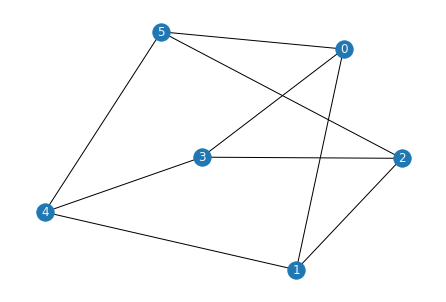

In [7]:
problem = get_random_maxcut_qp(degree=3, num_nodes=6, seed=3, draw=True)
print(problem.export_as_lp_string())

In [8]:
# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian operator
encoding.encode(problem)

# This is our encoded operator
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) "
    f"≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( 2.9999999999999996 * XX
+ 2.9999999999999996 * XY
+ 2.9999999999999996 * XZ
+ 2.9999999999999996 * YX
+ 2.9999999999999996 * ZX
+ 2.9999999999999996 * YY
+ 2.9999999999999996 * YZ
+ 2.9999999999999996 * ZY
+ 2.9999999999999996 * ZZ ).

We achieve a compression ratio of (6 binary variables : 2 qubits) ≈ 3.0.



In [9]:
# Create a QuantumInstance for solving the relaxed Hamiltonian using VQE
relaxed_qi = QuantumInstance(backend=Aer.get_backend("aer_simulator"), shots=1024)

# Set up the variational quantum eigensolver (ansatz width is determined by the encoding)
vqe = VQE(
    ansatz=RealAmplitudes(encoding.num_qubits),
    optimizer=SPSA(maxiter=50),
    quantum_instance=relaxed_qi,
)

# Use semideterministic rounding, known as "Pauli rounding"
# in https://arxiv.org/pdf/2111.03167v2.pdf
# (This is the default if no rounding scheme is specified.)
rounding_scheme = SemideterministicRounding()

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(
    encoding=encoding, min_eigen_solver=vqe, rounding_scheme=rounding_scheme
)

In [10]:
# Solve the optimization problem
results = qrao.solve(problem)
qrao_fval = results.fval
print(results)

fval=18.0, x0=0, x1=1, x2=0, x3=1, x4=0, x5=1, status=SUCCESS
